# Feature Ablation to Inspect ResNet Decisions

This notebook tutorial demonstrates how feature ablation in Captum can be applied to inspect computer vision models. 

**Task:** Classification into ImageNet-1k categories

**Model:** A ResNet18 trained on ImageNet-1k

**Data to inspect:** Samples from PASCAL VOC 2012

**Ablation based on:** Segmentation masks

We will use the visualization functions in Captum to show how each semantic part impacts the model output.
  
This tutorial assumes the following packages are installed: `captum`, `matplotlib`, `numpy`, `PIL`, `torch`, and `torchvision`.

problems solved in the following cell:

problem solved in the following cell, which was complitely changed with respect to the original:

The error arises because the keys in the state_dict do not match the expected keys in the model. This mismatch typically happens when the model was saved using torch.nn.DataParallel, which prefixes the parameter names with module..

To fix this, you need to adjust the state_dict by removing the module. prefix from the keys before loading it into the model. 

Why This Happens: When a model is wrapped in torch.nn.DataParallel, it adds a module. prefix to all parameter keys. The mismatch occurs if the model you instantiate doesn't expect this prefix.
Solution: Remove the module. prefix to make the keys match the expected keys in your model.



In [1]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision import models

from captum.attr import visualization as viz
from captum.attr import FeatureAblation

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from models.models_for_cub import ResNet  # Ensure the path is correct for your ResNet class

# Step 1: Define the model architecture
model = ResNet(pre_trained=False, n_class=200, model_choice=50)

# Step 2: Load and modify the state_dict
state_dict = torch.load(
    "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet/CNN_classifier/model_save/ResNet50.pkl",
    map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)
# Remove `module.` prefix
new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}
model.load_state_dict(new_state_dict)

# Step 3: Set the model to evaluation mode
model.eval()

#check for GPU usage
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/ResNet_Captum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/ResNet_Captum/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/ResNet_Captum/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_33123/881745071.py:19: FutureWarning: You 

PyTorch version: 2.5.1+cu124
CUDA available: True


## 1. Loading the model and the dataset

Let us load the pretrained `resnet18` model available in `torchvision` and set it to eval mode.

This model will serve as a classifier into the ImageNet-1k categories.

In [2]:
resnet = models.resnet50(pretrained=True)
resnet = resnet.eval()

/mnt/cimec-storage6/users/samuele.antonelli/miniconda3/envs/ResNet_Captum/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


A straightforward way to demonstrate feature ablation on images is to ablate semantic image areas.

Therefore, we will load sample images from PASCAL VOC, as these images come along with annotated segmentation masks.

**Note**: The VOC dataset is 2GB. If you do not want to download it, you can skip the next step and provide your own image and segmentation mask in the step next.

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from models.models_for_cub import ResNet
from cub import cub200
from utils.Config import Config
from PIL import Image
import matplotlib.pyplot as plt




# Define dataset transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Prepare dataset and dataloaders
train_dataset = cub200(root=Config.data_path, train=True, transform=train_transform)
test_dataset = cub200(root=Config.data_path, train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize the ResNet50 model
model = ResNet(pre_trained=True, n_class=200, model_choice=50).to('cuda' if torch.cuda.is_available() else 'cpu')

# Print model architecture
print(model)



Train file has been extracted
Test file has been extracted
ResNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): Re

Let us look at a sample image along with its segmentation mask:

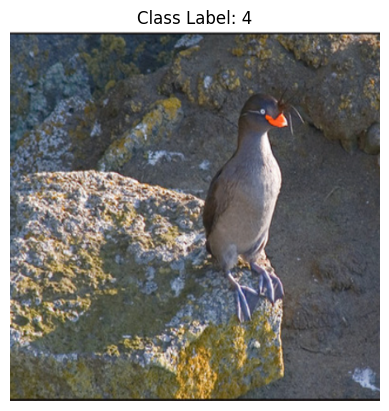

In [19]:
# Define a sample index
sample_ind = 136

#original code:
'''
img = Image.open(dataset.images[sample_ind])
plt.imshow(img); plt.axis('off'); plt.show()
mask_img = Image.open(dataset.masks[sample_ind])
plt.imshow(mask_img); plt.axis('off'); plt.show()
'''

# Access the image and label from the dataset
img, label = train_dataset[sample_ind]  # Replace train_dataset with your dataset object

# If the dataset applies normalization, reverse it for display
unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Un-normalize the image tensor
img = unnormalize(img)

# Convert the tensor image to a PIL image
img_pil = transforms.ToPILImage()(img)

# Display the image
plt.imshow(img_pil)
plt.title(f"Class Label: {label}")
plt.axis('off')
plt.show()



According to the segmentation mask, the image contains three bottles, and two TV monitors, with the rest considered background. All of `background`, `bottle`, and `tvmonitor` are among the 20 categories in PASCAL VOC 2012. This dataset also features a `void` category, used to annotate pixels that are not considered part of any class. These pixels represent border between the objects in the above example.

Let us also load ImageNet class labels to understand the output when we classify the samples using a classifier trained on ImageNet-1k.

**Note**: wget should be available as a command in your environment. You might need to install it. You can skip the next two steps if you are OK with class index as classification output (in that case, use `classify` in the next sections with `print_result`=`False`). 

In [20]:
#herw we parse the classes.txt file to create a mapping of class indices to bird species names.
# Path to the CUB-200-2011 classes.txt file
classes_file = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet/CNN_classifier/CUB_200_2011/classes.txt"

# Create a dictionary mapping index -> class name
idx_to_class = {}
with open(classes_file, 'r') as f:
    for line in f:
        class_id, class_name = line.strip().split(' ', 1)
        idx_to_class[int(class_id) - 1] = class_name  # Convert to 0-based indexing


## 2. Baseline classification

Let us define a function for classifying images using our ResNet. This model produces logits as classification scores. To normalize these logits into probabilities, we process the output with a `softmax` layer.

In [21]:
# uses torchvision transforms to convert a PIL image to a tensor and normalize it


img_to_resnet_input = T.Compose([
 T.ToTensor(),
 T.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )    
])

def classify(img, print_result=True):
    output = resnet(img_to_resnet_input(img).unsqueeze(0))
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    prediction_score.squeeze_()
    pred_label_idx.squeeze_()
    if print_result:
        # Replace the ImageNet labels with CUB-200-2011 class labels
        classes_file = "/mnt/cimec-storage6/users/samuele.antonelli/modifica_resnet/CNN_classifier/CUB_200_2011/classes.txt"
        idx_to_labels = {}
        with open(classes_file, 'r') as f:
            for line in f:
                class_id, class_name = line.strip().split(' ', 1)
                idx_to_labels[int(class_id) - 1] = class_name  # Convert to 0-based indexing

        # Map prediction index to bird species name
        predicted_label = idx_to_labels[pred_label_idx.item()]
        print('Predicted:', predicted_label, "id =", pred_label_idx.item(), 'with a score of:', prediction_score.item())

    return pred_label_idx.item(), prediction_score.item()

print(type(img))


    
    #original code:
'''
    if print_result:
        labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
        with open(labels_path) as json_data:
            idx_to_labels = json.load(json_data)
        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
        print('Predicted:', predicted_label, "id =", pred_label_idx.item(), 'with a score of:', prediction_score.squeeze().item())
    return pred_label_idx.item(), prediction_score.item()
'''



<class 'torch.Tensor'>


'\n    if print_result:\n        labels_path = os.getenv("HOME") + \'/.torch/models/imagenet_class_index.json\'\n        with open(labels_path) as json_data:\n            idx_to_labels = json.load(json_data)\n        predicted_label = idx_to_labels[str(pred_label_idx.item())][1]\n        print(\'Predicted:\', predicted_label, "id =", pred_label_idx.item(), \'with a score of:\', prediction_score.squeeze().item())\n    return pred_label_idx.item(), prediction_score.item()\n'

Now, let us classify the image we loaded in the previous section:

in the following cell i added the lines 1-5 to trace back the torch tensor to a PIL image, since it wanted 

In [22]:
from torchvision.transforms.functional import to_pil_image

# Convert img to PIL.Image if it's a Tensor
if isinstance(img, torch.Tensor):
    img = to_pil_image(img)

predicted_class, prediction_score = classify(img)

Predicted: 021.Eastern_Towhee id = 20 with a score of: 0.08188711106777191


Our model classifies the image as the ImageNet-1k category `wine_bottle`. Not bad.

<em>Note that the model is trained for classification, and expects images containing one object not a whole scene.</em>

Now, let us see how different parts of the image influence this output.

## 3. Inspecting influential image parts behind the classification output

With the availability of a segmentation mask, we can quickly exclude parts of the image to see how they affect the classification output.

The Feature Ablation algorithm in Captum enables ablating a number of input features together as a group. This is very useful when dealing with images, where each color channel in each pixel is an input feature.
To define our desired groups over input features, all we need is to provide a <em>feature mask</em>.

In case of an image input, the feature mask is also a 2D image of the same size, where each pixel in the mask indicates the feature group it belongs to via an integer value. Pixels of the same value define a group.

This means we can readily use segmentation masks as feature masks in Captum! 
Let us see how:

In [23]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from models.models_for_cub import ResNet
from cub import cub200
from utils.Config import Config
import numpy as np

# Define dataset transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Prepare dataset and dataloaders
train_dataset = cub200(root=Config.data_path, train=True, transform=train_transform)
test_dataset = cub200(root=Config.data_path, train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)  # Batch size = 1 for individual ablation
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

# Initialize the ResNet50 model
model = ResNet(pre_trained=True, n_class=200, model_choice=50).to('cuda' if torch.cuda.is_available() else 'cpu')

# Define function to generate grid masks
def generate_grid_masks(image, grid_size=(4, 4)):
    """
    Generate a list of masks dividing the image into a grid.

    Args:
        image (torch.Tensor): Input image of shape (C, H, W).
        grid_size (tuple): Number of grid cells (rows, cols).

    Returns:
        List[torch.Tensor]: A list of masks for each grid cell.
    """
    _, h, w = image.shape
    cell_h, cell_w = h // grid_size[0], w // grid_size[1]
    masks = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            mask = torch.zeros_like(image)
            mask[:, i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w] = 1
            masks.append(mask)
    return masks

# Perform grid-based ablation on test data
for i, (image, label) in enumerate(test_loader):
    image = image.squeeze(0)  # Remove batch dimension, shape: (C, H, W)
    label = label.item()  # Extract the label

    # Generate grid masks
    grid_masks = generate_grid_masks(image, grid_size=(4, 4))

    # Apply ablation to each grid region
    for mask in grid_masks:
        ablated_image = image * (1 - mask)  # Ablate the masked region
        ablated_image = ablated_image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')  # Add batch dimension

        # Pass the ablated image through the model
        output = model(ablated_image)
        
        # Process the model's output (e.g., log predictions)
        predicted_class = torch.argmax(output, dim=1).item()
        print(f"Image {i}, Label: {label}, Predicted Class: {predicted_class}")

    # Break after processing a few examples for demonstration
    if i > 4:
        break


Train file has been extracted
Test file has been extracted


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [37]:
for i, (image, label) in enumerate(test_loader):
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
    output = model(image)
    predicted_class = torch.argmax(output, dim=1).item()
    print(f"Image {i}, Label: {label.item()}, Predicted Class: {predicted_class}")
    if i > 5:
        break

# Evaluate training accuracy
correct = 0
total = 0
for image, label in train_loader:
    image = image.to('cuda' if torch.cuda.is_available() else 'cpu')
    label = label.to('cuda' if torch.cuda.is_available() else 'cpu')
    output = model(image)
    predicted = torch.argmax(output, dim=1)
    correct += (predicted == label).sum().item()
    total += label.size(0)
print(f"Training Accuracy: {correct / total:.2%}")



Image 0, Label: 0, Predicted Class: 140
Image 1, Label: 0, Predicted Class: 140
Image 2, Label: 0, Predicted Class: 140
Image 3, Label: 0, Predicted Class: 140
Image 4, Label: 0, Predicted Class: 140
Image 5, Label: 0, Predicted Class: 140
Image 6, Label: 0, Predicted Class: 140
Training Accuracy: 0.48%


In [28]:
# convert the mask image to a numpy array of the expected shape (count, channels, height, width)
feature_mask = np.array(mask_img.getdata()).reshape(1, 1, mask_img.size[1], mask_img.size[0])

NameError: name 'mask_img' is not defined

Our `feature_mask` is basically ready to use. However, let us first check its unique values that define the group ids:

In [29]:
print(np.unique(feature_mask))

NameError: name 'feature_mask' is not defined

These ids correspond to the VOC labels for `background`, `bottle`, `tvmonitor` and `void`.

While they would work, Captum expects consecutive group ids and would hence consider that there are 256 feature groups (most of them empty). This would result in slow execution.

Let's instead map our groups to consecutive values as expected by Captum:


In [11]:
feature_mask[feature_mask == 5] = 1 # feature group for bottle
feature_mask[feature_mask == 20] = 2 # feature group for tvmonitor
feature_mask[feature_mask == 255] = 3 # feature group for void


Now we can create our `FeatureAblation` object and use it to compute the influence of each feature group in our image on the target responsible for the `predicted_class` we computed in the previous section, which is `wine_bottle`

In [34]:
ablator = FeatureAblation(resnet)

attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=predicted_class,
    feature_mask=torch.tensor(feature_mask))

NameError: name 'feature_mask' is not defined

Let us visualize the resulting attribution map:

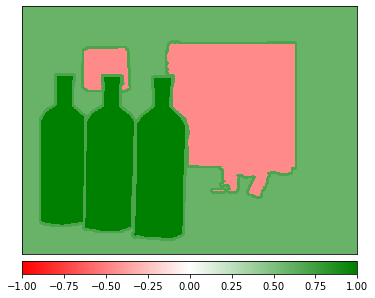

In [13]:
attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map, (1,2,0))
_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)



Captum has computed the influence of each feature groups on the predicted label `wine_bottle`:
* The bottles are the most influential part of the image contributing positively towards this prediction. Ablating them would strongly impact the prediction.
* The background and borders are less infuential.
* The TV monitors have a slightly negative impact. Ablating them will actually boost the prediction score for `wine_bottle`, as this reduces the clutter in the input image w.r.t. to this class.

The attribution map has been computed with `target=predicted_class`. Captum can further compute attribution maps for alternative targets.

## 4. Inspecting influential image parts for alternative classification

ImageNet does have a class for a TV monitor with `class_id = 664` according to the `idx_to_labels` map we loaded in section 1.

Let us compute an attribution map for this target in the same image:

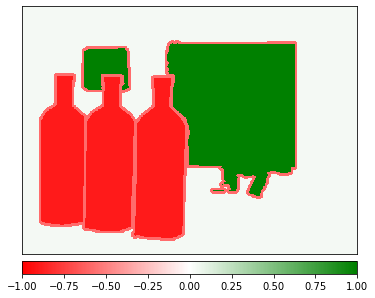

In [14]:
attribution_map = ablator.attribute(
    img_to_resnet_input(img).unsqueeze(0),
    target=664,
    feature_mask=torch.tensor(feature_mask))

attribution_map = attribution_map.squeeze().cpu().detach().numpy()
# adjust shape to height, width, channels 
attribution_map = np.transpose(attribution_map,  (1,2,0))

_ = viz.visualize_image_attr(attribution_map,
                             method="heat_map",
                             sign="all",
                             show_colorbar=True)




Captum has computed the influence of each feature groups on the target `monitor`:
* The TV monitors are expectedly the most influential part.
* The background has no infuential.
* The borders seem to have some negative impact. Ablating them slightly boosts the target, possibly because this helps framing the monitors in the image? 
* The bottles have a considerable negative impact. Ablating them apparently makes the monitors stand out as the main object in the image, which in turns boosts the activation for this target.

You can verify this finding next if you are interested.

## 5. Sanity check: re-classifying after ablation

Here we use OpenCV's `bitwise_and` to create an image with ablated bottles and borders:

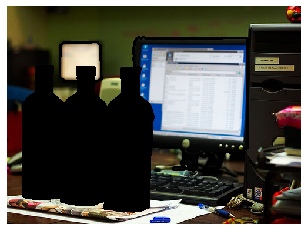

In [15]:
import cv2

cV2_mask = np.array(feature_mask)
cV2_mask[feature_mask == 0] = 1
cV2_mask[feature_mask == 1] = 0
cV2_mask[feature_mask == 2] = 1
cV2_mask[feature_mask == 3] = 0
cV2_mask = np.expand_dims(cV2_mask.squeeze(), axis=2).astype(np.uint8)

img_arr = np.transpose(T.ToTensor()(img).numpy(),  (1,2,0))
img_without_bottles = cv2.bitwise_and(img_arr, img_arr, mask=cV2_mask)
plt.imshow(img_without_bottles); plt.axis('off'); plt.show()


Let us classify this ablated image:

In [16]:
classify(img_without_bottles)

Predicted: desktop_computer  id =  527  (score:  0.10873227566480637 )


(527, 0.10873227566480637)

The output is `desktop_computer`, another class in ImageNet whose images usuallly include a monitor and a keyboard. Not bad.

In fact, the `monitor` class (with id = 664) is among the top-5 guesses:

In [17]:
output = resnet(img_to_resnet_input(img_without_bottles).unsqueeze(0))
output = F.softmax(output, dim=1)
torch.topk(output, 5)

torch.return_types.topk(
values=tensor([[0.1087, 0.0971, 0.0961, 0.0801, 0.0727]], grad_fn=<TopkBackward>),
indices=tensor([[527, 681, 673, 782, 664]]))